
# Mini Optim Autoregressive — **Perplexity-Focused** (SGD vs Adam vs Lion)

This version replaces top‑1 **accuracy** with **perplexity** as the main metric, while keeping:
- **Train/Val loss**
- **Generalization gap** (val_loss − train_loss)
- **Gradient/parameter norms**
- **Sharpness proxy** via input‑embedding FGSM
- **Run‑to‑run variance** (multi‑seed helper)

Default model/tokenizer: `flax-community/gpt-neo-125M-code-clippy`. Dataset: `bigcode/the-stack-smol` (python subset).


In [ ]:

# @title Setup
!pip -q install torch>=2.2 transformers>=4.44 datasets>=2.20 tqdm matplotlib pyyaml


In [ ]:

# @title Imports and Config
import os, glob, csv, math, random, sys, shutil, time
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

CFG = {
    "run": {
        "seed": 1337,
        "out_dir": "out",
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "steps": 3000,
        "log_every": 50,
        "eval_every": 200,
    },
    "train": {
        "batch_size": 8,
        "seq_len": 512,
        "lr": 3.0e-4,
        "weight_decay": 0.01,
        "grad_clip": 1.0,
        "dataset_size": 3000,
    },
    "hf": {
        "model_name": "flax-community/gpt-neo-125M-code-clippy",
        "tokenizer_name": "flax-community/gpt-neo-125M-code-clippy",
        "data_root": "../data/",
    },
    "landscape": {
        "grid_n": 17,
        "span": 0.5,
        "ckpt_glob": "out/adam_*/best.pt",
    }
}

Path(CFG["run"]["out_dir"]).mkdir(parents=True, exist_ok=True)
os.makedirs(CFG["hf"]["data_root"], exist_ok=True)
print("Device:", CFG["run"]["device"])


Device: cuda


In [ ]:

# @title (Optional) Save outputs directly to Google Drive
USE_COLAB = "google.colab" in sys.modules
DRIVE_BASE = "/content/drive/MyDrive" if USE_COLAB else None

def enable_drive(project_dir="mini_optim_autoregressive_runs_new"):
    global CFG
    if not USE_COLAB:
        print("Not running in Colab; skipping drive mount.")
        return
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    out_dir = os.path.join(DRIVE_BASE, project_dir, time.strftime("%Y-%m-%d_%H-%M"))
    CFG["run"]["out_dir"] = out_dir
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print("Writing runs to:", out_dir)

enable_drive()  # uncomment on Colab


Mounted at /content/drive
Writing runs to: /content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31


In [ ]:

# @title HF-style AutoRegressiveDataset
class AutoRegressiveDataset(Dataset):
    def __init__(self, data_path='../data/', max_length=2048, dataset_size=10000, tokenizer_name='gpt2', device='cuda'):
        super().__init__()
        self.max_length = max_length
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        if not self.tokenizer.pad_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.dataset = self._load_autoregressive(
            data_path=data_path,
            max_length=self.max_length,
            dataset_size=dataset_size
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_ids = self.dataset[idx]
        pad_id = self.tokenizer.pad_token_id or 0
        if len(input_ids) < self.max_length:
            input_ids = input_ids + [pad_id] * (self.max_length - len(input_ids))
        else:
            input_ids = input_ids[: self.max_length]
        x = torch.tensor(input_ids, dtype=torch.long).to(self.device)
        return x, x.clone().detach()

    def _load_autoregressive(self, data_path='../data/', max_length=2048, dataset_size=10000):
        dataset_path = os.path.join(data_path, 'autoregressive_dataset.pth')
        if os.path.exists(dataset_path):
            dataset = torch.load(dataset_path)
        else:
            ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split=f"train[0:{dataset_size}]")
            ds = ds.shuffle(seed=123)
            dataset = [self.tokenizer.encode(row['content'])[:max_length] for row in tqdm(ds, desc="Tokenizing")]
            torch.save(dataset, dataset_path)
        return dataset


def make_loaders(tokenizer_name: str, data_root: str, seq_len: int, batch_size: int, dataset_size: int, device: str):
    full = AutoRegressiveDataset(
        data_path=data_root,
        max_length=seq_len,
        dataset_size=dataset_size,
        tokenizer_name=tokenizer_name,
        device=device,
    )
    n = len(full)
    split = int(0.9 * n)
    idx_train = list(range(0, split))
    idx_val   = list(range(split, n))
    train_subset = torch.utils.data.Subset(full, idx_train)
    val_subset   = torch.utils.data.Subset(full, idx_val)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, val_loader


In [ ]:

# @title Model builder (same fresh init across optimizers)
def build_model(model_name: str, device: str):
    cfg = AutoConfig.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_config(cfg)
    return model.to(device)


In [ ]:

# @title Lion optimizer (minimal)
from torch.optim.optimizer import Optimizer

class Lion(Optimizer):
    def __init__(self, params, lr=3e-4, betas=(0.9, 0.99), weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @staticmethod
    def sign(x):
        return x.sign()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            wd = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = p.detach().new_zeros(p.shape)
                m = state['exp_avg']
                if wd != 0:
                    p.data.add_(p.data, alpha=-wd*lr)
                m.data.mul_(beta1).add_(g, alpha=1-beta1)
                p.data.add_(self.sign(m), alpha=-lr)
                m.data.mul_(beta2).add_(g, alpha=1-beta2)
                p.data.add_(self.sign(m), alpha=-lr)
        return loss


In [ ]:

# @title Utils: seed, optimizer factory, BPB/PPL, norms, sharpness proxy
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_optimizer(name, params, lr, weight_decay):
    name = name.lower()
    if name == 'adam':
        return torch.optim.Adam(params, lr=1e-4, weight_decay=weight_decay)
    elif name == 'sgd':
        return torch.optim.SGD(params, lr=3e-5, momentum=0.9, weight_decay=weight_decay)
    elif name == 'lion':
        return Lion(params, lr=2e-4, betas=(0.9, 0.99), weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

def bpb_from_loss(loss):
    return loss / math.log(2.0)

def ppl_from_loss(loss):
    # loss is NLL in nats/token
    return float(math.exp(loss))

def grad_global_norm(model):
    total_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            g = p.grad.detach().float()
            total_sq += float(torch.dot(g.view(-1), g.view(-1)))
    return total_sq ** 0.5

def param_global_norm(model):
    with torch.no_grad():
        total_sq = 0.0
        for p in model.parameters():
            if p.requires_grad:
                v = p.detach().float()
                total_sq += float(torch.dot(v.view(-1), v.view(-1)))
        return total_sq ** 0.5

def sharpness_proxy(model, x, y, eps=1e-2):
    model.eval()
    emb = model.get_input_embeddings()
    with torch.enable_grad():
        e = emb(x)
        e = e.detach().requires_grad_(True)
        clean = model(inputs_embeds=e, labels=y).loss
        clean.backward()
        adv_e = e + eps * e.grad.sign()
        with torch.no_grad():
            adv = model(inputs_embeds=adv_e, labels=y).loss
    return float((adv - clean).item()), float(clean.item()), float(adv.item())

def eval_sharpness_on_val(model, val_loader, batches=2, eps=1e-2, device="cuda"):
    it = iter(val_loader)
    deltas = []
    for _ in range(batches):
        x, y = next(it)
        d, *_ = sharpness_proxy(model, x, y, eps=eps)
        deltas.append(d)
    if len(deltas) == 1:
        return float(deltas[0]), 0.0
    return float(np.mean(deltas)), float(np.std(deltas, ddof=1))


In [ ]:

# @title Evaluate → returns (avg_loss, ppl, bpb)
def evaluate(model, loader, device):
    model.eval()
    tot_loss, n_batches = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            out = model(input_ids=x, labels=y)
            loss = out.loss
            tot_loss += loss.item()
            n_batches += 1
    avg_loss = tot_loss / max(1, n_batches)
    return avg_loss, ppl_from_loss(avg_loss), bpb_from_loss(avg_loss)


In [ ]:

# @title Train one run (logs loss, ppl, gap, norms, sharpness)
def train_one(opt_name: str, CFG):
    set_seed(CFG["run"]["seed"])
    device = CFG["run"]["device"]
    out_dir = Path(CFG["run"]["out_dir"]) / f"{opt_name}_seed{CFG['run']['seed']}"
    out_dir.mkdir(parents=True, exist_ok=True)

    train_loader, val_loader = make_loaders(
        tokenizer_name=CFG["hf"]["tokenizer_name"],
        data_root=CFG["hf"]["data_root"],
        seq_len=CFG["train"]["seq_len"],
        batch_size=CFG["train"]["batch_size"],
        dataset_size=CFG["train"]["dataset_size"],
        device=device,
    )

    model = build_model(CFG["hf"]["model_name"], device)
    opt = get_optimizer(opt_name, model.parameters(), CFG["train"]["lr"], CFG["train"]["weight_decay"])

    best, best_path = float("inf"), out_dir / "best.pt"
    step, total_steps = 0, CFG["run"]["steps"]
    pbar = tqdm(total=total_steps, desc=f"{opt_name}")

    itr = iter(train_loader)
    header = ["step","train_loss","val_loss","val_ppl","val_bpb","gap_loss","grad_norm","param_norm"]
    rows = [header]

    while step < total_steps:
        try:
            x, y = next(itr)
        except StopIteration:
            itr = iter(train_loader)
            x, y = next(itr)

        model.train()
        out = model(input_ids=x, labels=y)
        train_loss = out.loss

        for p in model.parameters():
            if p.grad is not None:
                p.grad = None
        train_loss.backward()

        g_norm = grad_global_norm(model)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["train"]["grad_clip"])
        opt.step()

        step += 1
        if step % CFG["run"]["log_every"] == 0:
            val_loss, val_ppl, val_bpb = evaluate(model, val_loader, device)
            gap_loss = val_loss - float(train_loss.item())
            p_norm = param_global_norm(model)
            rows.append([
                step, f"{float(train_loss.item()):.4f}",
                f"{val_loss:.4f}", f"{val_ppl:.4f}", f"{val_bpb:.4f}",
                f"{gap_loss:.4f}", f"{g_norm:.4f}", f"{p_norm:.4f}"
            ])
            pbar.set_postfix(train=f"L{train_loss.item():.3f}",
                             val=f"L{val_loss:.3f}/PPL{val_ppl:.2f}")

        if step % CFG["run"]["eval_every"] == 0:
            val_loss, _, _ = evaluate(model, val_loader, device)
            if val_loss < best:
                best = val_loss
                torch.save({"model": model.state_dict(), "cfg": CFG}, best_path)

        pbar.update(1)

    # end-of-run sharpness proxy
    sh_mean, sh_std = eval_sharpness_on_val(model, val_loader, batches=2, eps=1e-2, device=device)
    with open(out_dir / "summary.txt","w") as f:
        f.write(f"best_val_loss={best:.6f}\nsharpness_delta_mean={sh_mean:.6f}\nsharpness_delta_std={sh_std:.6f}\n")

    with open(out_dir / "log.csv", "w", newline="") as f:
        writer = csv.writer(f); writer.writerows(rows)

    return out_dir


sgd:   0%|          | 0/3000 [00:00<?, ?it/s]

adam:   0%|          | 0/3000 [00:00<?, ?it/s]

lion:   0%|          | 0/3000 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/convergence_loss.png
Saved /content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/convergence_ppl.png
Saved /content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/convergence_gap_loss.png


[PosixPath('/content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/sgd_seed1337'),
 PosixPath('/content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/adam_seed1337'),
 PosixPath('/content/drive/MyDrive/mini_optim_autoregressive_runs_new/2025-10-05_22-31/lion_seed1337')]

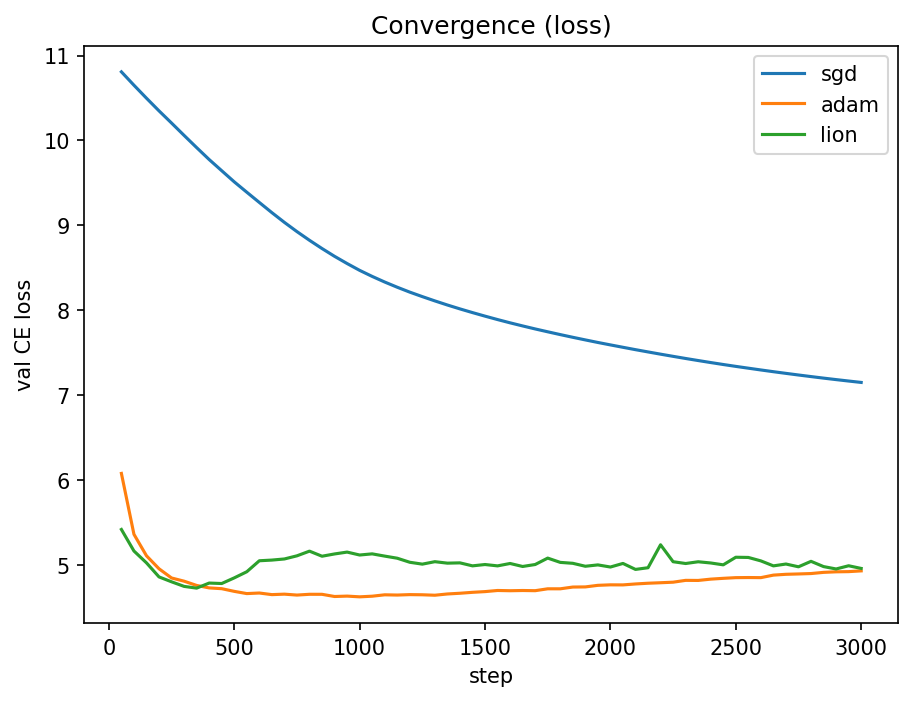

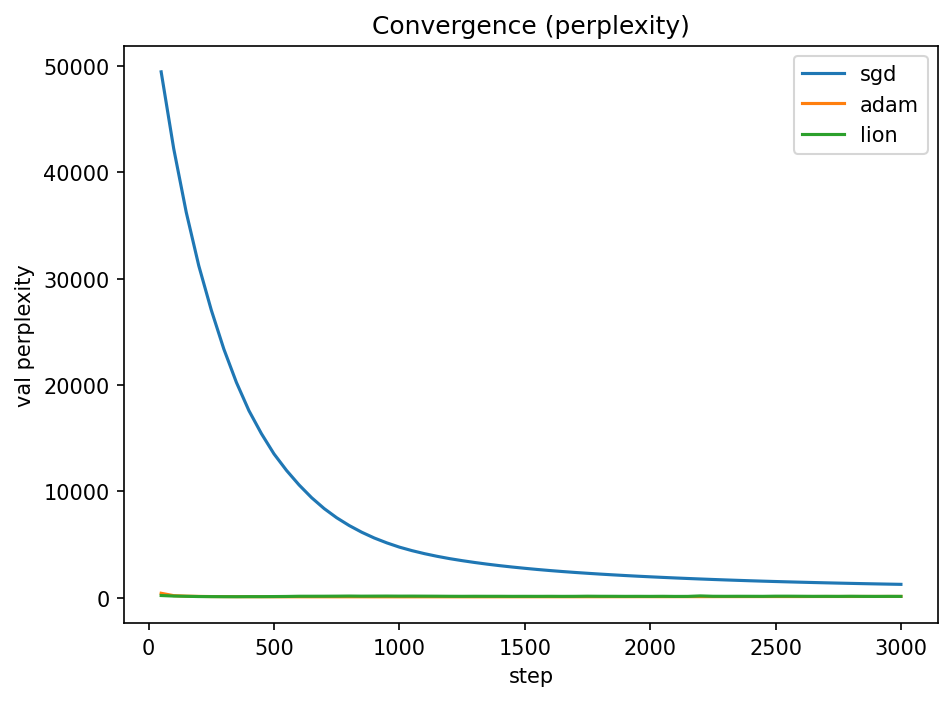

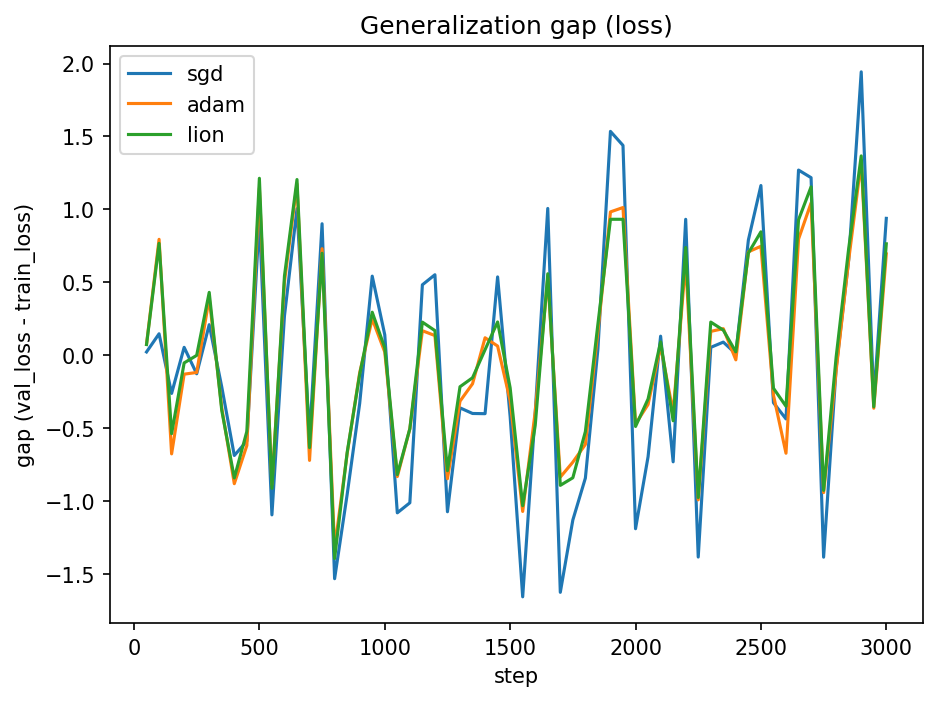

In [ ]:

# @title Run Convergence (returns run dirs) + plots (loss, ppl, gap)
def run_convergence(CFG):
    runs = []
    for name in ["sgd","adam","lion"]:
        runs.append(train_one(name, CFG))

    # Plot val CE loss
    plt.figure(figsize=(7,5), dpi=150)
    for run in runs:
        path = Path(run) / "log.csv"
        steps, vals = [], []
        with open(path) as f:
            r = csv.DictReader(f)
            for row in r:
                steps.append(int(row["step"]))
                vals.append(float(row["val_loss"]))
        label = run.name.split("_")[0]
        plt.plot(steps, vals, label=label)
    plt.xlabel("step"); plt.ylabel("val CE loss"); plt.legend(); plt.title("Convergence (loss)")
    out_png_loss = Path(CFG["run"]["out_dir"]) / "convergence_loss.png"
    plt.savefig(out_png_loss, bbox_inches="tight")
    print("Saved", out_png_loss)

    # Plot val perplexity
    plt.figure(figsize=(7,5), dpi=150)
    for run in runs:
        path = Path(run) / "log.csv"
        steps, ppls = [], []
        with open(path) as f:
            r = csv.DictReader(f)
            for row in r:
                steps.append(int(row["step"]))
                ppls.append(float(row["val_ppl"]))
        label = run.name.split("_")[0]
        plt.plot(steps, ppls, label=label)
    plt.xlabel("step"); plt.ylabel("val perplexity"); plt.legend(); plt.title("Convergence (perplexity)")
    out_png_ppl = Path(CFG["run"]["out_dir"]) / "convergence_ppl.png"
    plt.savefig(out_png_ppl, bbox_inches="tight")
    print("Saved", out_png_ppl)

    # Plot generalization gap (loss)
    plt.figure(figsize=(7,5), dpi=150)
    for run in runs:
        path = Path(run) / "log.csv"
        steps, gaps = [], []
        with open(path) as f:
            r = csv.DictReader(f)
            for row in r:
                steps.append(int(row["step"]))
                gaps.append(float(row["gap_loss"]))
        label = run.name.split("_")[0]
        plt.plot(steps, gaps, label=label)
    plt.xlabel("step"); plt.ylabel("gap (val_loss - train_loss)"); plt.legend(); plt.title("Generalization gap (loss)")
    out_png_gap = Path(CFG["run"]["out_dir"]) / "convergence_gap_loss.png"
    plt.savefig(out_png_gap, bbox_inches="tight")
    print("Saved", out_png_gap)

    return runs

run_convergence(CFG)

In [11]:

# @title Multi-seed helper: run-to-run variance (loss & ppl)
def run_many(CFG, seeds=(1227, 2027, 3407), opts=("sgd","adam","lion")):
    results = {}  # {opt: [(val_loss, val_ppl), ...]}
    for opt in opts:
        results[opt] = []
        for sd in seeds:
            CFG_ = {k:(v.copy() if isinstance(v, dict) else v) for k,v in CFG.items()}
            CFG_["run"]["seed"] = sd
            out = train_one(opt, CFG_)
            with open(Path(out)/"log.csv") as f:
                rows = list(csv.DictReader(f))
            final = rows[-1]
            results[opt].append((float(final["val_loss"]), float(final["val_ppl"])))
    # summarize
    summary_rows = [["optimizer","val_loss_mean","val_loss_std","val_ppl_mean","val_ppl_std","n_runs"]]
    for opt, arr in results.items():
        vl = np.array([x[0] for x in arr]); vp = np.array([x[1] for x in arr])
        summary_rows.append([opt, f"{vl.mean():.4f}", f"{vl.std(ddof=1):.4f}",
                             f"{vp.mean():.4f}", f"{vp.std(ddof=1):.4f}", len(arr)])
    with open(Path(CFG["run"]["out_dir"]) / "multi_seed_summary.csv", "w", newline="") as f:
        writer = csv.writer(f); writer.writerows(summary_rows)
    return results

run_many(CFG)


sgd:   0%|          | 0/3000 [00:00<?, ?it/s]

sgd:   0%|          | 0/3000 [00:00<?, ?it/s]

sgd:   0%|          | 0/3000 [00:00<?, ?it/s]

adam:   0%|          | 0/3000 [00:00<?, ?it/s]

adam:   0%|          | 0/3000 [00:00<?, ?it/s]

adam:   0%|          | 0/3000 [00:00<?, ?it/s]

lion:   0%|          | 0/3000 [00:00<?, ?it/s]

lion:   0%|          | 0/3000 [00:00<?, ?it/s]

lion:   0%|          | 0/3000 [00:00<?, ?it/s]

{'sgd': [(7.2101, 1352.9952), (7.1978, 1336.5241), (7.1738, 1304.802)],
 'adam': [(4.9333, 138.8327), (4.9235, 137.4877), (4.9374, 139.4038)],
 'lion': [(4.9027, 134.6586), (5.2107, 183.2257), (5.1321, 169.3712)]}

In [12]:

# # @title Loss Landscape (2D slice) utilities and runner (loss only)
# def flatten_params(model):
#     with torch.no_grad():
#         return torch.cat([p.detach().flatten() for p in model.parameters() if p.requires_grad])

# def add_direction(model, direction, alpha):
#     i = 0
#     with torch.no_grad():
#         for p in model.parameters():
#             if not p.requires_grad:
#                 continue
#             n = p.numel()
#             delta = direction[i:i+n].view_as(p)
#             p.add_(delta, alpha=alpha)
#             i += n

# def run_landscape(CFG):
#     device = CFG["run"]["device"]
#     ckpts = sorted(glob.glob(CFG["landscape"]["ckpt_glob"]))
#     if not ckpts:
#         raise FileNotFoundError(f"No checkpoints match: {CFG['landscape']['ckpt_glob']}")
#     ckpt_path = ckpts[0]
#     print("Using checkpoint:", ckpt_path)

#     train_loader, val_loader = make_loaders(
#         tokenizer_name=CFG["hf"]["tokenizer_name"],
#         data_root=CFG["hf"]["data_root"],
#         seq_len=CFG["train"]["seq_len"],
#         batch_size=CFG["train"]["batch_size"],
#         dataset_size=CFG["train"]["dataset_size"],
#         device=device,
#     )

#     model = build_model(CFG["hf"]["model_name"], device)
#     state = torch.load(ckpt_path, map_location=device)
#     model.load_state_dict(state["model"])

#     w = flatten_params(model)
#     g1 = torch.randn_like(w); g1 = g1 / (g1.norm() + 1e-12)
#     g2 = torch.randn_like(w); g2 = g2 / (g2.norm() + 1e-12)

#     n = CFG["landscape"]["grid_n"]
#     span = CFG["landscape"]["span"]
#     alphas = torch.linspace(-span, span, n)
#     betas  = torch.linspace(-span, span, n)
#     Z = np.zeros((n, n), dtype=np.float32)

#     base_state = {k: v.clone() for k, v in model.state_dict().items()}

#     with torch.no_grad():
#         for i, a in enumerate(tqdm(alphas, desc="landscape rows")):
#             for j, b in enumerate(betas):
#                 model.load_state_dict(base_state, strict=True)
#                 add_direction(model, g1, float(a))
#                 add_direction(model, g2, float(b))
#                 val_loss, _, _ = evaluate(model, val_loader, device)
#                 Z[i, j] = val_loss

#     A, B = np.meshgrid(alphas.cpu().numpy(), betas.cpu().numpy(), indexing="ij")
#     plt.figure(figsize=(6,5), dpi=150)
#     cs = plt.contourf(A, B, Z, levels=30)
#     plt.colorbar(cs, label="val CE loss")
#     plt.xlabel("alpha"); plt.ylabel("beta"); plt.title("Loss Landscape (2D slice)")
#     out_dir = Path(CFG["run"]["out_dir"])
#     out_dir.mkdir(parents=True, exist_ok=True)
#     np.save(out_dir / "landscape.npy", Z)
#     plt.savefig(out_dir / "landscape.png", bbox_inches="tight")
#     print("Saved", out_dir / "landscape.png", "and landscape.npy")
